## After collecting the data in the previous step, we will do text preprocessing in this step

In [1]:
!pip install transformers




### Import libraries

In [2]:
#Libraries for Text preprocessing 
import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

#Normal computation libraries
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#Libraries for modelling
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from collections import defaultdict
from textwrap import wrap

#Pytorch libraries
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import os

#Set the Random Seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
#Check for gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


ModuleNotFoundError: No module named 'torch'

In [5]:
import warnings
warnings.simplefilter('ignore')

### Read the data

In [6]:
#Read the reviews
df = pd.read_csv('Train.csv')
df.head()

,ID,content,score
0,65479,Revoyez vos prix ainsi que la lenteur ke prend...,0
1,84256,تجربة ممتازة وشيقة فعلا تعاملاتهم محترمة ماعدا...,1
2,31581,دفو على نصابين,-1
3,58926,J arriver à temps et malheureusement je me re...,1
4,17945,Je suis contente des services rendu par Jumia....,1


In [7]:
#We will remove the id for simplicity
df.drop('ID', axis = 1, inplace = True)
df["score"].replace({-1:0,0:1,1:2,}, inplace=True)
df.head()

,content,score
0,Revoyez vos prix ainsi que la lenteur ke prend...,1
1,تجربة ممتازة وشيقة فعلا تعاملاتهم محترمة ماعدا...,2
2,دفو على نصابين,0
3,J arriver à temps et malheureusement je me re...,2
4,Je suis contente des services rendu par Jumia....,2


In [8]:
#Get the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59408 entries, 0 to 59407
Data columns (total 2 columns):
content    59408 non-null object
score      59408 non-null int64
dtypes: int64(1), object(1)
memory usage: 928.4+ KB


In [9]:
df['score'].value_counts()

2    38797
0    16057
1     4554
Name: score, dtype: int64

Text(0, 0.5, 'Score counts')

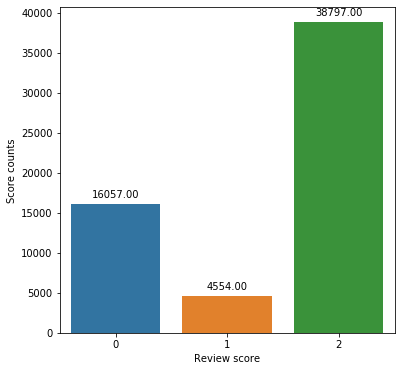

In [10]:
#We are interested in score, let's check the distribution
plt.rcParams['figure.figsize'] = 6, 6
review_count = sns.countplot(df.score)
class_name = [0,1,2]
for p in review_count.patches:
    review_count.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel("Review score")
plt.ylabel("Score counts")

In [14]:
# first we sample the data with frac=1(to keep the data size) and random_state = 4 (to shuffle the dataset)
shuffled_df = df.sample(frac=1,random_state=4)

# earlier observation showed us that Neutral class label has lowest rows so we keep it as it is
neutral_rows = shuffled_df.loc[shuffled_df['score']== 1].sample(n=4554)

# but we sample Negative and Positive classes with sample size n = 4554 (which is the total no of Neutral classes)
negative_rows = shuffled_df.loc[shuffled_df['score'] == 0].sample(n=4554)
positive_rows = shuffled_df.loc[shuffled_df['score']== 2].sample(n=4554)

# we concat the rows of all the classes
normalized_df = pd.concat([neutral_rows, negative_rows, positive_rows])

# and we shuffle it again
df = normalized_df.sample(frac=1,random_state=10)

Text(0, 0.5, 'Score counts')

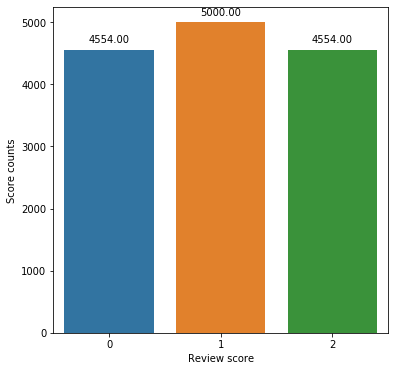

In [15]:
plt.rcParams['figure.figsize'] = 6, 6
review_count = sns.countplot(df.score)
class_name = [0,1,2]
for p in review_count.patches:
    review_count.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xlabel("Review score")
plt.ylabel("Score counts")

### Data Preprocessing

We need to convert the text to numbers using tokenizer. For training data, BERT requires extra steps like
1. BERT needs special tokens indicating starting and ending of sentence, and special tokens for classification. 
2. The input must be of fixed length (padding for less tokens)
3. Create attention mask indicating importance of token

In [11]:
#Define the BERT Model
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'   #Cased better here for sentiment analysis might have more weight here

In [12]:
#Set the tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
#Create a sample sentence for analysis
sample = 'I love NLP. It is very interesting to play with words. Do you like NLP?'

tokens = tokenizer.tokenize(sample)
print("Sentence: ", sample)
print("Tokens: ",tokens)

#Get the ids of tokens from BERT vocab
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print("Token ids: ", token_ids)

Sentence:  I love NLP. It is very interesting to play with words. Do you like NLP?
Tokens:  ['I', 'love', 'NL', '##P', '.', 'It', 'is', 'very', 'interesting', 'to', 'play', 'with', 'words', '.', 'Do', 'you', 'like', 'NL', '##P', '?']
Token ids:  [146, 1567, 21239, 2101, 119, 1135, 1110, 1304, 5426, 1106, 1505, 1114, 1734, 119, 2091, 1128, 1176, 21239, 2101, 136]


In [14]:
encoding = tokenizer.encode_plus(
  sample,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [15]:
#Separator token
print(tokenizer.sep_token, tokenizer.sep_token_id)
#Classification token
print(tokenizer.cls_token, tokenizer.cls_token_id)
#Unknown token
print(tokenizer.unk_token, tokenizer.unk_token_id)

[SEP] 102
[CLS] 101
[UNK] 100


In [16]:
token_lens = []
#Iterate through all content of reviews
for text in df.content:
    tokens = tokenizer.tokenize(text)
    token_lens.append(len(tokens))

Text(0, 0.5, '% of counts')

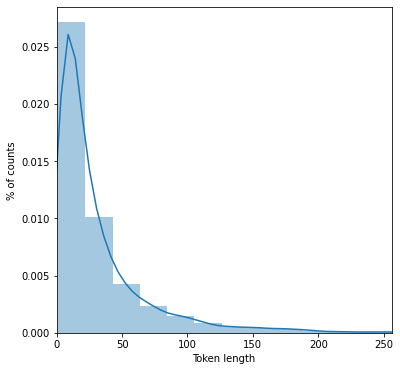

In [17]:
#Get the distribution plot
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token length')
plt.ylabel('% of counts')

In [18]:
MAX_LEN = 202

### Create the class for Pytorch Dataset for apps reviews

In [19]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [20]:
#Split the data into train and test
df_train, df_val = train_test_split(df, test_size=0.05, random_state=RANDOM_SEED)
#this line is for a testing data set we dont need it in our case
#df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [22]:
#Check the shapes
#df_train.shape, df_val.shape, df_test.shape
df_train.shape, df_val.shape

((12978, 2), (684, 2))

Create the data loader 

In [23]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.content.to_numpy(),
        targets=df.score.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
      )

In [26]:
#Create the data loaders
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [27]:
#Check the data loader
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [28]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 202])
torch.Size([16, 202])
torch.Size([16])


### As we have preprocessed the text, we will fine-tune BERT for sentiment analysis. Rather than using BERTForSequenceClassification or BERTForQuestionAnswering, we will use BERT model and build our own classifier

In [29]:
#Load the BERT Model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)

In [30]:
#Encode the sample text
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [31]:
#Check the shape of last hidden state(Output of the last encoder of BERT)
last_hidden_state.shape

torch.Size([1, 32, 768])

As our length of example sentence is 32, we have hidden state of each token

In [32]:
#Pooling is applied using BertPooling for simplicity
pooled_output.shape

torch.Size([1, 768])

In [33]:
#We can check the number of hidden units in BERT using config
bert_model.config.hidden_size

768

#### Create a Sentiment Classifier

In [34]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME, return_dict=False)
        self.drop = nn.Dropout(p=0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = self.drop(pooled_output)
        return self.out(output)

In [35]:
#Create instance
model = SentimentClassifier(len(class_name))
model = model.to(device)

In [36]:
#Move the example batch to GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [37]:
#Get the shape of input ids and attention masks
print(input_ids.shape)
print(attention_mask.shape)

torch.Size([16, 202])
torch.Size([16, 202])


In [38]:
#To get the predicted probability for each class, we will apply a softmax layer on the output

F.softmax(model(input_ids, attention_mask), dim = 1)

tensor([[0.4259, 0.1971, 0.3771],
        [0.5814, 0.1337, 0.2849],
        [0.3105, 0.1479, 0.5416],
        [0.4313, 0.1950, 0.3737],
        [0.5702, 0.1583, 0.2715],
        [0.3884, 0.1988, 0.4128],
        [0.4112, 0.1193, 0.4695],
        [0.2808, 0.2678, 0.4514],
        [0.3842, 0.1883, 0.4275],
        [0.3439, 0.2085, 0.4477],
        [0.4208, 0.2003, 0.3790],
        [0.4357, 0.1739, 0.3904],
        [0.5867, 0.1016, 0.3117],
        [0.4820, 0.1887, 0.3293],
        [0.4378, 0.1996, 0.3625],
        [0.4237, 0.2118, 0.3646]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### Train the model

In [39]:
#Set the parameters for training as per recommendation by HuggingFace
EPOCHS = 30

#We will use AdamW optimizer 
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
#Set the total steps
total_steps = len(train_data_loader) * EPOCHS

#Set the scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#Define the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [40]:
#Define a method for training the data
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    #Set the model in training mode
    model=model.train()
    
    losses = []
    correct_predictions = 0
    
    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
        
        #Get the output
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        #Get the max of softmax
        _, preds = torch.max(outputs, dim=1)
        
        #Calculate the loss
        loss = loss_fn(outputs, targets)
        
        #Update loss and correct prediction
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        #Perform training actions
        loss.backward()
        nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)     #Normalize gradients to prevent explosion
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

In [41]:
#Define a method for evaluating the model
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [42]:
#Train the model for 4 epochs
from collections import defaultdict
#Define history and best accuracy
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    
    print(f'Epoch: {epoch + 1} / {EPOCHS}')
    print('-' * 15)

    #Call the train epoch method
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

    #Print the loss and accuracy
    print(f'Train loss: {train_loss}, Train accuracy: {train_acc}')


    #Call the val epoch method
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

    #Print the validation loss and accuracy
    print(f'Validation loss: {val_loss}, Validation accuracy: {val_acc}')
    train_acc=train_acc.item()
    val_acc=val_acc.item()
    #Update the history dictionary
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
      if os.path.isfile('best_model_state.bin'):
        os.remove('best_model_state.bin')                  
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

Epoch: 1 / 30
---------------
Train loss: 1.083207813389783, Train accuracy: 0.410926182770843
Validation loss: 0.9945604260577712, Validation accuracy: 0.5014619883040935
Epoch: 2 / 30
---------------
Train loss: 0.9216237597057385, Train accuracy: 0.5648019725689629
Validation loss: 0.8714092595632686, Validation accuracy: 0.6081871345029239
Epoch: 3 / 30
---------------
Train loss: 0.8028611879190201, Train accuracy: 0.6381568808753275
Validation loss: 0.8514333540617034, Validation accuracy: 0.6359649122807017
Epoch: 4 / 30
---------------
Train loss: 0.700181788966757, Train accuracy: 0.6976421636615812
Validation loss: 0.8869158667187358, Validation accuracy: 0.641812865497076
Epoch: 5 / 30
---------------
Train loss: 0.6065240622213651, Train accuracy: 0.7502696871628911
Validation loss: 0.9953565112380094, Validation accuracy: 0.6505847953216374
Epoch: 6 / 30
---------------
Train loss: 0.5345678750134252, Train accuracy: 0.7840191092618277
Validation loss: 1.0828205776769062, 

(0.6, 1.0)

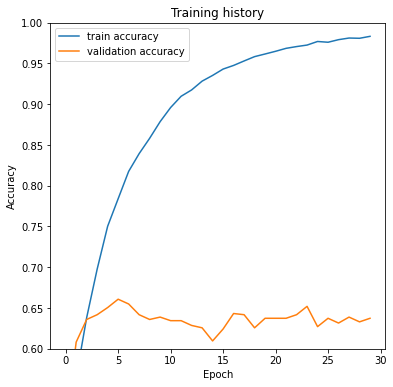

In [43]:
#PLot the graphs to compare accuracy
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.6, 1])

## Evaluation

In [44]:
model.load_state_dict(torch.load("/content/best_model_state.bin"))
#these 2 lines is for a testing data set we dont need it in our case
#test_accuracy = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
#print("Test accuracy: ", test_accuracy[0].item())

<All keys matched successfully>

## Function to get the predictions

In [45]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [46]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

NameError: ignored

In [ ]:
print(classification_report(y_test, y_pred,labels=class_name))

In [47]:
# Check sample
idx = 80
review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({'class_name': class_name, 'values': y_pred_probs[idx]})
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_name[true_sentiment]}')
sns.barplot(x='values', y='class_name', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

NameError: ignored

## Prediction on user input

In [48]:
review_text = "rakom ki zeby"

In [49]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [50]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

Review text: rakom ki zeby
Sentiment  : 0


In [51]:
data_test = pd.read_csv('Test.csv')
data_test.head()

,ID,content
0,2,Beaucoup de défauts se bloque toujours et pas ...
1,8,Application trés lente Le smartphone chauffe e...
2,10,Toujours des erreurs surtout lorsquil faut ent...
3,12,La durée pour la publication dune annonce dépa...
4,13,Lapplication plante très souvent peu de temps ...


In [52]:
pred_text = data_test.content.to_numpy()

In [ ]:
predections=[]
for e in pred_text:
  encoded_review = tokenizer.encode_plus(
  e,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  print(f'Review text: {e}')
  print(f'Sentiment  : {class_name[prediction]}')
  predections.append(class_name[prediction])
  


Streaming output truncated to the last 5000 lines.
Sentiment  : 1
Review text: For bzf
Sentiment  : 1
Review text: i dont like 
Sentiment  : 0
Review text: commandes faciles
Sentiment  : 2
Review text: نصب في نصب
Sentiment  : 0
Review text: تحيا الجزائر تحيا الجزائر تحيا الجزائر
Sentiment  : 2
Review text: Very very cool app
Sentiment  : 1
Review text: bravo 
Sentiment  : 2
Review text: Excellent App 
Sentiment  : 2
Review text: Très bien
Sentiment  : 2
Review text: EXTRA-ORDINAIRE 
Sentiment  : 1
Review text: Uj
Sentiment  : 1
Review text: tooooop
Sentiment  : 2
Review text: Very
Sentiment  : 2
Review text: ناررر
Sentiment  : 2
Review text: Bogjg
Sentiment  : 1
Review text: مان
Sentiment  : 1
Review text: Mmerci
Sentiment  : 2
Review text: ؤؤر
Sentiment  : 1
Review text: Intéressés
Sentiment  : 1
Review text: والو
Sentiment  : 2
Review text: Adaman
Sentiment  : 0
Review text: Très excellent .
Sentiment  : 2
Review text: احسنتم
Sentiment  : 2
Review text: Supe
Sentiment  : 2
Review tex

In [ ]:
data_test["score"]=predections
data_test.head()

In [ ]:
data_test.drop('content', axis = 1, inplace = True)
data_test["score"]=data_test["score"]-1
data_test.head()

In [ ]:
df_submission=pd.read_csv('SampleSubmission.csv')
df_submission.head()

In [ ]:
df.to_csv(r'Predections.csv', index = False)
